<a href="https://colab.research.google.com/github/RuthKassahun/Skin-Lesion-Classification/blob/main/Glcm_feature_extractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GLCM Feature Extractor

## Import Libraries

In [71]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import os
import seaborn as sns
import pandas as pd
from skimage.filters import sobel
from skimage.feature import greycomatrix, greycoprops
from skimage.measure import shannon_entropy
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import metrics
from pathlib import Path
import xgboost as xgb
import lightgbm as lgb
from PIL import Image, ImageOps
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, auc, roc_curve, roc_auc_score, recall_score, confusion_matrix


## Load Data

In [2]:
print(os.listdir("/content/drive/MyDrive/train/sample_train"))
SIZE = 224

['other', 'nevus']


In [3]:
train_images = []
train_labels = [] 
#for directory_path in glob.glob("cell_images/train/*"):
for directory_path in glob.glob("/content/drive/MyDrive/train/sample_train/*"):
    label = directory_path.split("/")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        print(img_path)
        img = cv2.imread(img_path, 0) #Reading color images
        img = cv2.resize(img, (SIZE, SIZE)) #Resize images
        train_images.append(img)
        train_labels.append(label)
        
train_images = np.array(train_images)
train_labels = np.array(train_labels)

other
/content/drive/MyDrive/train/sample_train/other/bcc01352.jpg
/content/drive/MyDrive/train/sample_train/other/mel00423.jpg
/content/drive/MyDrive/train/sample_train/other/mel02307.jpg
/content/drive/MyDrive/train/sample_train/other/bkl00221.jpg
/content/drive/MyDrive/train/sample_train/other/bkl01101.jpg
/content/drive/MyDrive/train/sample_train/other/bkl00327.jpg
/content/drive/MyDrive/train/sample_train/other/mel02208.jpg
/content/drive/MyDrive/train/sample_train/other/bcc01114.jpg
/content/drive/MyDrive/train/sample_train/other/bkl00870.jpg
/content/drive/MyDrive/train/sample_train/other/mel01310.jpg
/content/drive/MyDrive/train/sample_train/other/bkl00706.jpg
/content/drive/MyDrive/train/sample_train/other/ack00427.jpg
/content/drive/MyDrive/train/sample_train/other/mel01755.jpg
/content/drive/MyDrive/train/sample_train/other/mel00755.jpg
/content/drive/MyDrive/train/sample_train/other/mel02367.jpg
/content/drive/MyDrive/train/sample_train/other/mel00172.jpg
/content/drive/MyD

In [ ]:
train_images

In [ ]:
print(train_labels)

In [10]:
test_images = []
test_labels = []
#for directory_path in glob.glob("cell_images/test/*"): 
for directory_path in glob.glob("/content/drive/MyDrive/val/sample_val/*"):
    test_label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, 0)
        img = cv2.resize(img, (SIZE, SIZE))
        test_images.append(img)
        test_labels.append(test_label)
        
test_images = np.array(test_images)
test_labels = np.array(test_labels)


## Label Encoding

In [16]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [21]:
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded


## GLCM Extractor

In [22]:
def feature_extractor(dataset):
  image_dataset  = pd.DataFrame()
  distance = [1, 3, 5, 8]
  angle = [0, np.pi/4, np.pi/2, 3*np.pi/4]
  for image in range(dataset.shape[0]):
    img = dataset[image]
    df = pd.DataFrame()
    count = 1
    for dist in distance:
      for ang in angle:
        GLCM = greycomatrix(img, [dist], [ang])      
        GLCM_Energy = greycoprops(GLCM, 'energy')[0]
        df[f'Energy{count}'] = GLCM_Energy
        GLCM_corr = greycoprops(GLCM, 'correlation')[0]
        df[f'Corr{count}'] = GLCM_corr             
        GLCM_hom = greycoprops(GLCM, 'homogeneity')[0]
        df[f'Homogen{count}'] = GLCM_hom       
        GLCM_contr = greycoprops(GLCM, 'contrast')[0]
        df[f'Contrast{count}'] = GLCM_contr
        count = count + 1
    image_dataset = image_dataset.append(df)    
  return image_dataset

In [27]:
image_features = feature_extractor(x_train)
X_for_ML =image_features

In [26]:
image_features = feature_extractor(x_test)
X_test_ML =image_features

In [32]:
X_test_ML.shape[0]

725

In [ ]:
X_for_ML

## SVM

In [33]:
pipe1 = Pipeline([
                 ("scale", StandardScaler()),
                 ("classifier", SVC(class_weight='balanced', probability=True, kernel= 'rbf', gamma=0.01, C=100)) #radial basis function kernel
                 ])

In [36]:
pipe1.fit(X_for_ML,train_labels_encoded)

Pipeline(steps=[('scale', StandardScaler()),
                ('classifier',
                 SVC(C=100, class_weight='balanced', gamma=0.01,
                     probability=True))])

Accuracy: 72.41%


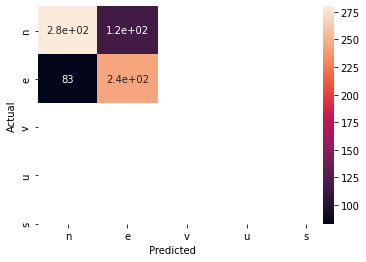

In [48]:
# Test set evaluation
prediction = pipe1.predict(X_test_ML)
# Visualization
cmat = metrics.confusion_matrix(prediction,test_labels_encoded)
s = sns.heatmap(cmat,annot=True,xticklabels=label, yticklabels=label)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))

In [49]:
prediction_prob = pipe1.predict_proba(X_test_ML)
print("Area under curve (AUC): ", roc_auc_score(test_labels_encoded, prediction_prob[:,1]))

Area under curve (AUC):  0.8033689481454425


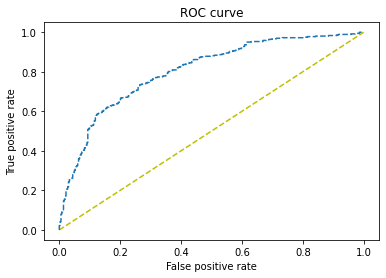

In [50]:
fpr, tpr, thresholds = roc_curve(test_labels_encoded, prediction_prob[:,1]) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

## Random Forest

In [51]:
pipe2 = Pipeline([
                 ("scale", StandardScaler()),
                 ("classifier", RandomForestClassifier(n_estimators = 100, random_state = 42))
                 ])

In [52]:
pipe2.fit(X_for_ML,train_labels_encoded)

Pipeline(steps=[('scale', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=42))])

Accuracy: 71.17%


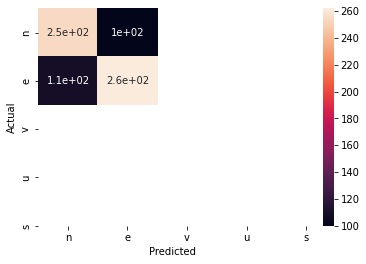

In [53]:
# Test set evaluation
prediction = pipe2.predict(X_test_ML)
# Visualization
cmat = metrics.confusion_matrix(prediction,test_labels_encoded)
s = sns.heatmap(cmat,annot=True,xticklabels=label, yticklabels=label)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))

In [54]:
prediction_prob = pipe2.predict_proba(X_test_ML)
print("Area under curve (AUC): ", roc_auc_score(test_labels_encoded, prediction_prob[:,1]))

Area under curve (AUC):  0.7749874434957308


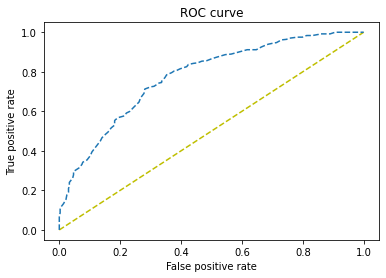

In [55]:
fpr, tpr, thresholds = roc_curve(test_labels_encoded, prediction_prob[:,1]) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

## KNN

In [56]:
pipe3 = Pipeline([
                 ("scale",StandardScaler()),
                 ("classifier", KNeighborsClassifier(n_neighbors=7))
                 ])

In [57]:
pipe3.fit(X_for_ML,train_labels_encoded)

Pipeline(steps=[('scale', StandardScaler()),
                ('classifier', KNeighborsClassifier(n_neighbors=7))])

In [64]:
prediction_prob = pipe3.predict_proba(X_test_ML)
print("Area under curve (AUC): ", roc_auc_score(test_labels_encoded, prediction_prob[:,1]))

Area under curve (AUC):  0.7504147451410135


Accuracy: 70.34%


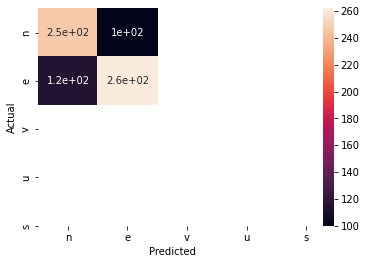

In [65]:
# Test set evaluation
prediction = pipe3.predict(X_test_ML)
# Visualization
cmat = metrics.confusion_matrix(prediction,test_labels_encoded)
s = sns.heatmap(cmat,annot=True,xticklabels=label, yticklabels=label)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))

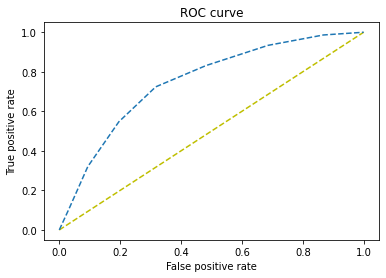

In [66]:
fpr, tpr, thresholds = roc_curve(test_labels_encoded, prediction_prob[:,1]) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

## AdaBoost

In [60]:
clf = AdaBoostClassifier(n_estimators=200, random_state=0)
clf.fit(X_for_ML,train_labels_encoded)

AdaBoostClassifier(n_estimators=200, random_state=0)

In [67]:
prediction_prob = clf.predict_proba(X_test_ML)
print("Area under curve (AUC): ", roc_auc_score(test_labels_encoded, prediction_prob[:,1]))

Area under curve (AUC):  0.718091259151028


Accuracy: 67.03%


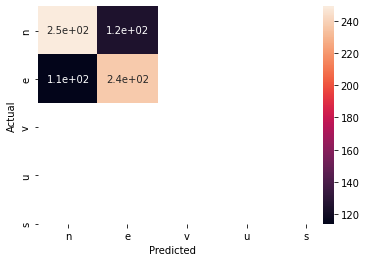

In [68]:
# Test set evaluation
prediction = clf.predict(X_test_ML)
# Visualization
cmat = confusion_matrix(prediction,test_labels_encoded)
s = sns.heatmap(cmat,annot=True,xticklabels=label, yticklabels=label)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))

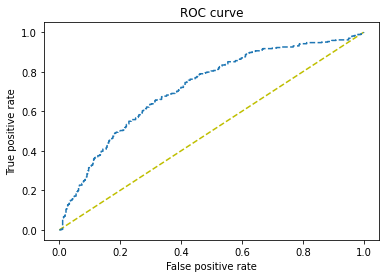

In [69]:
fpr, tpr, thresholds = roc_curve(test_labels_encoded, prediction_prob[:,1]) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

## XGB

In [72]:
mod1 = xgb.XGBClassifier(booster='dart',learning_rate=0.1)
train_arr = np.array(X_for_ML)
test_arr = np.array(X_test_ML)
mod1.fit(train_arr, train_labels_encoded)

XGBClassifier(booster='dart')

In [73]:
prediction = mod1.predict(test_arr)
print("Accuracy = ", accuracy_score(test_labels_encoded, prediction))

Accuracy =  0.7048275862068966


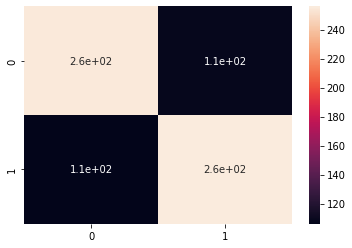

In [74]:
cm = confusion_matrix(test_labels_encoded, prediction)
sns.heatmap(cm, annot=True)

In [75]:
prediction_prob = mod1.predict_proba(test_arr)
print("Area under curve (AUC): ", roc_auc_score(test_labels_encoded, prediction_prob[:,1]))

Area under curve (AUC):  0.7703529519200036


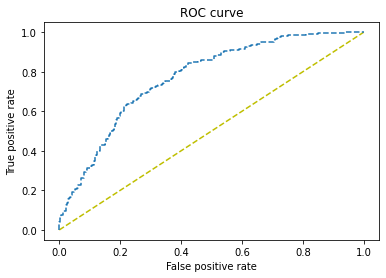

In [76]:
fpr, tpr, thresholds = roc_curve(test_labels_encoded, prediction_prob[:,1]) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

## LightGBM

In [79]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_for_ML)
test_scaled = scaler.transform(X_test_ML)
d_train = lgb.Dataset(train_scaled, label=train_labels_encoded)

In [80]:
lgbm_params = {'learning_rate':0.05, 'boosting_type':'gbdt', #Sometimes dart gives better accuracy. gbdt means gradient boosting.
              'objective':'binary',
              'metric':['auc', 'binary_logloss'],
              'num_leaves':100, # optimizing this avoids overfitting. 50 to 100
              'max_depth':10} #10 may be appropriate

In [81]:
clf = lgb.train(lgbm_params, d_train, 50) #50 iterations. Increase iterations for small learning rates. eg if learning grate = 0.005, we may need 500 iterations.
prediction=clf.predict(test_scaled)
#convert the probabilities into binary values 0/1 for classification
for i in range(0, test_scaled.shape[0]):
    if prediction[i]>=.5: # setting threshold to 0.5
       prediction[i]=1
    else:  
       prediction[i]=0

Accuracy with LGBM =  0.7006896551724138


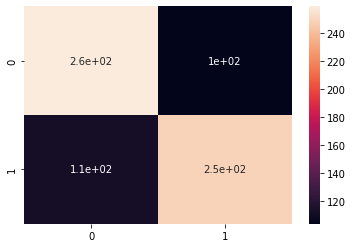

In [82]:
#Print accuracy
print ("Accuracy with LGBM = ", accuracy_score(test_labels_encoded, prediction))
#Confusion matrix
cm_lgbm = confusion_matrix(test_labels_encoded, prediction)
sns.heatmap(cm_lgbm, annot=True)

In [83]:
prediction_prob=clf.predict(test_scaled)
print("Area under curve (AUC): ", roc_auc_score(test_labels_encoded, prediction_prob))

Area under curve (AUC):  0.7701779218604934


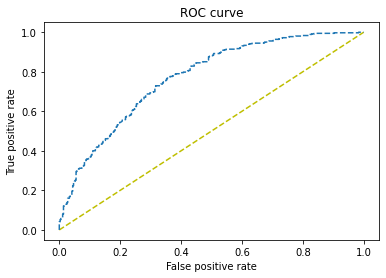

In [84]:
fpr, tpr, thresholds = roc_curve(test_labels_encoded, prediction_prob) # outputs false positive rate, true positive rate, and corresponding thresholds.
plt.figure(1)
plt.plot([0,1],[0,1], 'y--')
plt.plot(fpr, tpr, linestyle = '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()